# Popularity Prediction of User-Posts 
# on the website of Austrian Newspaper 'Der Standard

This noteboook deal with the challenge of prediction the popularity (measured by up- and downvotes) of user-posts in the comments-section under articles of the Austrian Newspaper 'Der Standard'.

## Step 0 Set Up

### Step 0.1 Load Libraries

As a first step we load in the necessary libraries that we will use to accomplish this task.

In [1]:
# Text processing
import re

# Data manipulation
import pandas as pd
import numpy as np
import sqlite3

# Graphics and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
# deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, concatenate

# evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


# for tracking time
from tqdm import tqdm




In [39]:
#!pip install visualkeras
import visualkeras

### Step 0.2 Load Data

In [2]:
# Relative path to the SQLite database file
database_file = "./data/corpus.sqlite3"

# Connect to the database
conn = sqlite3.connect(database_file)

# Query to fetch the first 100,000 rows from a table named 'your_table_name'
query = "SELECT * FROM Posts LIMIT 100000"

# Load data into a DataFrame
df_posts = pd.read_sql_query(query, conn)
df_articles = pd.read_sql_query("SELECT * FROM Articles", conn)

# Close the connection
conn.close()


## Step 1: Preprocessing

In [3]:
# Convert 'CreatedAt' and 'publishingDate' columns to datetime format
df_posts['CreatedAt'] = pd.to_datetime(df_posts['CreatedAt'], errors='coerce')
df_articles['publishingDate'] = pd.to_datetime(df_articles['publishingDate'], errors='coerce')

# Convert 'ID_Article' columns to numeric 
df_posts['ID_Article'] = pd.to_numeric(df_posts['ID_Article'], errors='coerce')
df_articles['ID_Article'] = pd.to_numeric(df_articles['ID_Article'], errors='coerce')

# Extracting the subtitle from the articles body
def extract_subtitle(html_content):
    match = re.search(r'<h2.*?>(.*?)<\/h2>', html_content)
    return match.group(1) if match else " "
df_articles['Subtitle'] = df_articles['Body'].apply(extract_subtitle)


# Merge the two DataFrames based on the 'ID_Article' column

# excluding the full articles body and only including title and subtitle in the merge
# as the body is usually quite long and might not contain valuable information for this analysis
df_articles.rename(columns={'Body': 'Body_Article'}, inplace=True)
columns_to_merge = df_articles.columns[df_articles.columns != 'Body_Article']

df_merged = pd.merge(df_posts, df_articles[columns_to_merge], on='ID_Article')

# Shuffle the dataset and reset index
df_merged = df_merged.sample(n=len(df_merged))
df_merged = df_merged.reset_index(drop=True)

## Step 2: Explorative Data Analysis 

In order to develop a feeling for the data, step 1 focuses on analyzing and visualizing the dataset.

### Step 2.1. Boxplot of Positive & Negative Votes

In order to get a feeling for how the values of Up- and Downvotes are distributed, we generate two boxplots, one for the upvotes feature, and one for the downvotes feature.

In [4]:
def make_box_plot(column, df):
    """
    Function to create a boxplot for a column in the dataframe
    Inputs:
    Name of the Column to make boxplot for (string)
    A Pandas data frame object 
    """

    # Set style
    sns.set_style("whitegrid")

    # Adjust the figure size
    plt.figure(figsize=(8, 2))

    # Create the box plot
    ax = sns.boxplot(x=df_posts[column], orient='h', fliersize=1, color='lightblue')

    # Set title
    ax.set_title("Distribution of " + column +  " (Log Scale)", fontsize=16)

    # Set x-axis label
    ax.set_xlabel("Number of "+ column, fontsize=14)

    # Remove y-axis label
    ax.set_ylabel("")

    # Set logarithmic scale for x-axis
    ax.set_xscale('log')

    # Set ticks on the x-axis
    custom_ticks = [1, 2, 3, 4, 5, 6, 8, 10, 20, 30, 50, 100, 500]
    plt.xticks(custom_ticks, [str(i) for i in custom_ticks], fontsize=16)

    # Remove top and right spines
    sns.despine()
    
    # Save the plot
    plt.savefig('./figures/boxplot_' + column + '.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.tight_layout()
    plt.show()

    


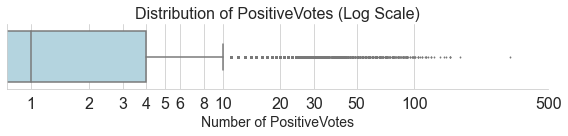

In [5]:
make_box_plot('PositiveVotes', df_posts)

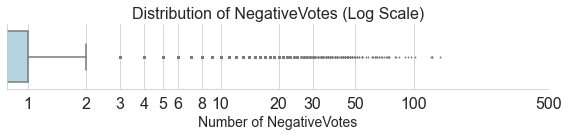

In [6]:
make_box_plot('NegativeVotes', df_posts)

### Step 2.2. Heatmap of Positive and Negtive Votes

In order to analyzse the distribution further, a heatmap is generated.

In [7]:
# Define custom intervals for PositiveVotes and NegativeVotes
positive_intervals = [(0, 0), (1, 1), (2, 3), (4, 9), (10, 19), (20, 49), (50, 99), (100, 500)]
negative_intervals = [(0, 0), (1, 1), (2, 3), (4, 9), (10, 19), (20, 49), (50, 99), (100, 500)]

# Create result DataFrame with named columns and rows
result_df = pd.DataFrame(0, index=[f'{interval[0]}-{interval[1]}' for interval in negative_intervals],
                         columns=[f'{interval[0]}-{interval[1]}' for interval in positive_intervals])

# Iterate through each post and update the count in the result DataFrame
for _, row in df_posts.iterrows():
    neg_interval = None
    pos_interval = None

    
    # Find the index of the negative interval
    for i, interval in enumerate(negative_intervals):
        if interval[0] <= row['NegativeVotes'] <= interval[1]:
            neg_interval = i
            break
            
    # Find the index of the positive interval
    for i, interval in enumerate(positive_intervals):
        if interval[0] <= row['PositiveVotes'] <= interval[1]:
            pos_interval = i
            break
    
    if neg_interval is not None and pos_interval is not None:
        result_df.iloc[neg_interval, pos_interval] += 1
        # row = interval for downvoates - column = interval for upvotes


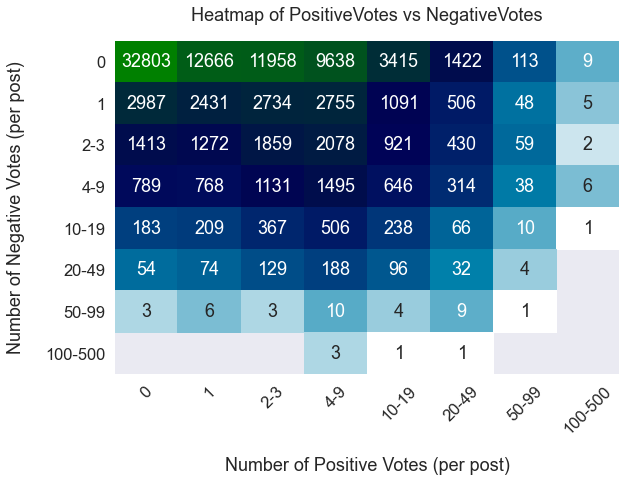

In [8]:

# Rename columns and index
result_df.rename(columns={'1-1': '1', '0-0': '0'}, 
                 index={'1-1': '1', '0-0': '0'}, 
                 inplace=True)

# Get the colormap 
cmap = cm.get_cmap('ocean')
# Flip the colormap
flipped_cmap = cmap.reversed()

# Set font scale for the heatmap and axis labels
sns.set(font_scale=1.5)  # Adjust font scale as needed

# Plot heatmap for PositiveVotes with logarithmic color scale
plt.figure(figsize=(10, 8))
sns.heatmap(result_df, cmap=flipped_cmap, annot=True, fmt='d', cbar=False, 
            norm=LogNorm(vmin=1, vmax=result_df.max().max()))
plt.title('Heatmap of PositiveVotes vs NegativeVotes', pad=20)  # Adjust title padding
plt.xlabel('Number of Positive Votes (per post)', labelpad=20)  # Adjust x label padding
plt.ylabel('Number of Negative Votes (per post)', labelpad=20)  # Adjust y label padding
plt.xticks(rotation=45)  # Rotate x ticks for better visibility
plt.yticks(rotation=0)   # Rotate y ticks for better visibility
plt.tight_layout(pad=3.0)  # Adjust padding between plot and figure edges


plt.savefig("./figures/heatmap.png", dpi=300, bbox_inches='tight' )
plt.show()


### Step 2.3. Overview of all posts

Next we generate an overview about how many posts have at least one vote (positive or negative), at least one positive or at least one negative votes.

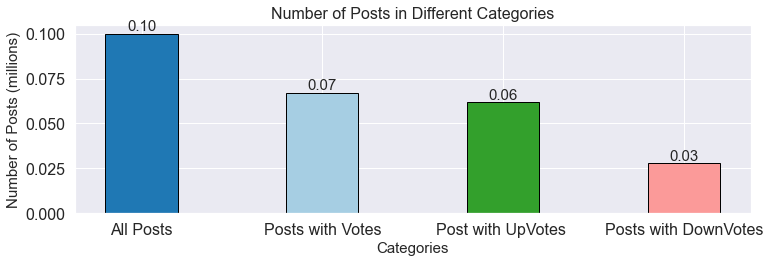

In [9]:
all_posts = df_posts["ID_Post"].count()
all_posts_with_votes = df_posts[(df_posts["PositiveVotes"] > 0) | (df_posts["NegativeVotes"] > 0)]["ID_Post"].count()
positive_posts = df_posts[(df_posts["PositiveVotes"] > 0)]["ID_Post"].count()
negative_posts = df_posts[(df_posts["NegativeVotes"] > 0)]["ID_Post"].count()

# Convert values to millions
all_posts /= 1e6
all_posts_with_votes /= 1e6
positive_posts /= 1e6
negative_posts /= 1e6

# Define categories and their corresponding values
categories = ['All Posts', 'Posts with Votes', 'Post with UpVotes ', 'Posts with DownVotes']
values = [all_posts, all_posts_with_votes, positive_posts, negative_posts]

# Choose a more suitable color palette
colors = ['#1F78B4', '#A6CEE3',   '#33A02C', '#FB9A99']
# Create bar plot
plt.figure(figsize=(11, 4))
bars = plt.bar(categories, values, color=colors, 
               edgecolor='black', width=0.4)  

# Add labels and title
plt.xlabel('Categories', fontsize=15)
plt.ylabel('Number of Posts (millions)', fontsize=15)
plt.title('Number of Posts in Different Categories', fontsize=16)

# Increase font size for tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Show the value on top of each bar with larger font size
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=15)

# Save the plot
plt.savefig('./figures/bar_plot.png', dpi=300, bbox_inches='tight')
# Show plot
plt.tight_layout()
plt.show()



In [10]:
print(f"The median number of Upvotes is: { df_posts.PositiveVotes.median() }")
print(f"The median number of Downvotes is: { df_posts.NegativeVotes.median() }")


print(f"The mean number of Upvotes is: { df_posts.PositiveVotes.mean() }")
print(f"The mean number of Downvotes is: { df_posts.NegativeVotes.mean() }")

The median number of Upvotes is: 1.0
The median number of Downvotes is: 0.0
The mean number of Upvotes is: 3.41457
The mean number of Downvotes is: 1.00318


### Step 2.4. Looking at the Data

Next we look at a few example for posts with more than 10 upvotes or posts with more than 10 downvotes.

In [11]:
df_posts[df_posts["PositiveVotes"]>10].head(10)[["Headline", "Body"]].style

,Headline,Body
108,,Ist es schon überarbeitet? Ich möchte wieder so berühmt werden wie früher. Das hat mir damals sagenhaft viele perverse Kontakte verschafft.
109,"""Multiuser"" und ""Bewertungsuser""?","Gibt es eine Meldeadresse/-stelle an die man sich wenden kann, wenn man annimmt einen ""Multiuser"" (mehrfach registrierten Benutzer) gefunden zu haben? Und was ist mit Usern die schon länger registriert sind, selbst 0 Postings verfasst haben und in Threads auffallend oft von oben bis unten durchgehend nur mit rot oder grün bewerten?"
157,Zugriff zu den eigenen ...,...posts bzw. Konto wäre eine gute Erweiterung....
189,"Oh, wie schön, heute ist m e i n Tag! :-)","Beste Grüße an alle Mit-Lefties dieser Erde und auch Nicht-Erde!!! Erfahrungen: # wirkliche Probleme, sehr eindrücklich als Kind zB beim Werken/Basteln, haben mir immer bestimmte Scheren gemacht (die z.B. dann total in der Hand weh tun, wenn links gehalten, oder einfach eher reißen als schneiden) # das eindrücklichste Erlebnis ist ein paar Jahre her: in einer Café-Lokation auf der Wiener Währinger Straße wurde mir meine Melange in einer Tasse serviert, deren ""ergonomisch"" schiefer/geschwungener Griff für eine rechte Hand (wohl) sehr gut passt - mit der linken Hand kann man das Häferl dadurch aber praktisch kaum halten... # beim Sporteln war mein Lefty-tum, glaub ich, immer nur ein Vorteil :-) ;-)"
206,,"wenn mir jemand bezüglich meiner handwerklichen Fähigkeiten gesagt hat, dass ich zwei Linke habe, habe ich mich für das Komplement bedankt."
215,,"am allerschlimmsten sind saucenschöpfer mit schnabel... da kann ich machen was ich will, ich kann diese teile einfach nicht bedienen.. die sauce rinnt überall hin, nur nicht auf den teller..."
289,,"Die Meinl-Häferln sind wirklich eine sinnlose Geschichte. Glückwunsch an den Designer für Hirnlosigkeit im Dienst - auch wenn es Linkshänder-Exemplare theoretisch geben tät, kein Restaurant würde die bestellen. Scheren sind ein kleines Problem, wobei ich mir mit einer Linkshänderschere auch weh tu - weil schon zu lange an die falschen Scheren gewohnt. Wenn man sich aber ausschließlich mit Linkshänderprodukten umgibt, ""sperrt"" man sih quasi von der dominierenden Rechtshänderwelt ab. Letztendlich drängt einem das Linkshändertum ein wenig, den Individualisten zu spielen - mir hat's nicht geschadet, oder ich merk's nicht."
297,,"Meine Großmutter hat mir mal erzählt, dass sie in der Schule noch geohrfeigt wurde, weil sie Linkshänderin war. Umlernen wurde gefordert, nicht nur in der Schule, sondern auch vom Elternhaus (natürlich auch mit Prügel verbunden) - kann mir nicht vorstellen, was für Leid das in einem Kind/Jugendlichen verursacht, wegen so einer Lappalie unter Druck gesetzt und verdroschen zu werden. Heute kann sie beide Hände fast gleich nutzen, präferiert bei den meisten Sachen jedoch die Linke."
347,,"Als Linkshänder, welcher die Computer Maus mit der rechten bedient, kann ich gleichzeitig etwas (ab)schreiben und mit der Maus am Computer zB Textstellen markieren und scrollen ;)"
386,UMFRAGE FÜR LINKSHÄNDER:,Benutzt ihr am PC/iThing die Maus/das Touchpad mit der linken oder rechten Hand? Links: grün Rechts: rot


In [12]:
df_posts[df_posts["NegativeVotes"]>10].head(10)[["Headline", "Body"]].style

,Headline,Body
235,,Zum Sport: Wer schießt (wie ich) beim Fußball mit rechts? Wer ist links unterwegs? rot=links grün=rechts
386,UMFRAGE FÜR LINKSHÄNDER:,Benutzt ihr am PC/iThing die Maus/das Touchpad mit der linken oder rechten Hand? Links: grün Rechts: rot
759,,"schön. Bis zu jenem Tag, als die Trabis die Mariahilferstraße verstopft haben mit den Waschmaschinen am Dachl."
884,,"Ich hab jene Ostdeutschen bedauert, die den Versprechungen von Kohl und Genscher geglaubt haben."
1085,,"Wenn das so schlimm war, wieso hast sie dann überhaupt wiedergesehen? Oder wars nur für eine Nacht?"
1113,,das is ja wirklich grauslich - ich hätt' Euch auch nicht rein gelassen
1120,,In London gibts außergewöhnlich gute Hotels. Man muss sie sich halt leisten können und wollen. ;-)
1123,,DAnn frage ich dich nochmal: Was war damals an dem Erlebnis so schlimm?
1129,,"Im Nachhinein ist was anderes, ich glaube, hier gehts darum, welches Hotelerlebnis man im Moment des Erlebens als schlimm empfand. Also eher off topic, hier von kaputten späteren Beziehungen zu plaudern. :-)"
1251,,"dann graust mir davor, wie Dich Deine Ex-Frau umgedreht hat *brr*"


Most interestingly we see here for example that users misuse the functionality the downvotes and upvotes to start a survey (as shown in the first two rows).

## Step 2: Feature Generation

Next we generate the features to train our models with.

In [13]:
# Calculate the time difference in hours between 'CreatedAt' and 'publishingDate'
df_merged['time_passed_before_post_creation'] = ( df_merged['CreatedAt'] - df_merged['publishingDate'] ).dt.total_seconds() / 60 / 60

# Rank the comments for each article based on the 'time_passed_before_post_creation'
df_merged['post_time_rank'] = df_merged.groupby('ID_Article')['time_passed_before_post_creation'].rank(method='first').astype(int)

# Calculate the percentage rank (to check if it's in the first 10%, 20%, etc.)
df_merged['time_percentile'] = df_merged.groupby('ID_Article')['time_passed_before_post_creation'].rank(pct=True)

# Create a column to define percentile category
def assign_percentile_category(percentile):
    if percentile <= 0.5:
        # First 10%, 20%, ... up to 50%
        return f"First {int(percentile * 10) * 10 +10}%"
    else:
        # Last 40%, 30%, ... up to 10%
        return f"Last {int((1 - percentile) * 10) * 10 +10}%"

df_merged['time_percentile_category'] = df_merged['time_percentile'].apply(assign_percentile_category)



In [14]:
df_articles

,ID_Article,Path,publishingDate,Title,Body_Article,Subtitle
0,1,Newsroom/User/Community,2012-05-26 03:00:19.230,Die Newsletter von derStandard.at,"<div class=""section"" id=""content-main"" itempro...",Abonnieren Sie einen unserer Newsletter und la...
1,2,Newsroom/User/Community/Regeln,2012-05-26 12:12:19.460,Werden Sie Teil von derStandard.at!,"<div class=""diashow"" id=""objectContent""><meta ...",
2,3,Diverses/mobil,2013-11-22 12:15:00.000,Die Android App von derStandard.at,"<div class=""section"" id=""content-main"" itempro...",Die Smartphone-App bietet Nachrichten in Echtz...
3,4,Newsroom/User/mitmachen/Mitreden,2014-08-13 05:30:00.000,Welche Erfahrungen haben Sie als Linkshänder g...,"<div class=""section"" id=""content-main"" itempro...",Wie sieht Ihr Alltag als Linkshänder aus? Erle...
4,5,Newsroom/User/mitmachen/Mitreden,2014-08-27 12:27:01.090,Wie haben Sie das Jahr 1989 erlebt?,"<div class=""section"" id=""content-main"" itempro...",Erzählen Sie uns von Ihren Erlebnissen rund um...
...,...,...,...,...,...,...
12082,12083,Newsroom/Kultur/Musikkultur,2016-05-31 16:14:13.000,Max Prosa: Junger Troubadour alter Schule,"<div class=""section"" id=""content-main"" itempro...",Von Popakademie und Creative Writing veredelte...
12083,12084,Newsroom/Etat/PRINT/Springer,2016-05-31 17:39:29.000,"""Können Adblocker nicht einfach hinnehmen""","<div class=""section"" id=""content-main"" itempro...",Medien müssten ihre Abhängigkeit von Anzeigen ...
12084,12085,Meinung/Kolumnen/rau,2016-05-31 17:34:54.000,Die Rechten machen Facebook zum Hatebook,"<div class=""section"" id=""content-main"" itempro...",Die FPÖ und ihre Hilfstruppen im Netz haben di...
12085,12086,Newsroom/Kultur/Buehne,2016-05-31 18:08:20.000,"""Wrestling Rita"": Feministischer Punktsieg im ...","<div class=""section"" id=""content-main"" itempro...",Im Theater Scala tobt ein Kampf um die Emanzip...


In [15]:


# Ensure 'PositiveVotes' and 'NegativeVotes' columns are numeric
df_merged['PositiveVotes'] = pd.to_numeric(df_merged['PositiveVotes'], errors='coerce')
df_merged['NegativeVotes'] = pd.to_numeric(df_merged['NegativeVotes'], errors='coerce')

# Create the 'Total_Interaction' column
df_merged['Total_Interaction'] = df_merged['PositiveVotes'] + df_merged['NegativeVotes']

# Count the number of posts per article (ID_Article)
post_counts = df_merged['ID_Article'].value_counts()

# Initialize a new column for engagement labels
df_merged['Post_Engagement'] = 'regular post'

# Iterate through each articleid to label the posts
for articleid, count in post_counts.items():
    # Filter posts for the current article
    article_posts = df_merged[df_merged['ID_Article'] == articleid]

    if count < 50:
        # Label all posts as "regular post" if there are fewer than 10 posts
        df_merged.loc[df_merged['ID_Article'] == articleid, 'Post_Engagement'] = 'regular post'
    else:
        # If there are 10 or more posts, calculate the top x% based on 'Total_Interaction'
        top_percentage = 40
        top_percentage_threshold = np.percentile(article_posts['Total_Interaction'], (100-top_percentage))

        # Label posts as 'top post' if their 'Total_Interaction' is >= the 90th percentile
        df_merged.loc[(df_merged['ID_Article'] == articleid) & 
                      (df_merged['Total_Interaction'] >= top_percentage_threshold), 'Post_Engagement'] = 'top post'

# Check the resulting labels
print(df_merged[['ID_Article', 'Total_Interaction', 'Post_Engagement']].head())


   ID_Article  Total_Interaction Post_Engagement
0         268                  3    regular post
1         141                  5    regular post
2         157                  2        top post
3        1314                  2    regular post
4        1395                  6        top post


In [16]:
df_merged[df_merged['ID_Article'] == 103]

,ID_Post,ID_Parent_Post,ID_Article,ID_User,CreatedAt,Status,Headline,Body,PositiveVotes,NegativeVotes,Path,publishingDate,Title,Subtitle,time_passed_before_post_creation,post_time_rank,time_percentile,time_percentile_category,Total_Interaction,Post_Engagement
4086,6105,NaN,103,16671,2015-06-03 23:55:11.810,online,None,"""...und der Eisverkäufer ruft ""Gelati Gelati""....",0,0,Kiaroom/Karriere/Job/Weiterbildung,2015-06-02 05:30:00,Eis verkaufen wie die Italiener,Nichtindustriell produziertes Speiseeis erlebt...,42.419947,8,0.666667,Last 40%,0,regular post
19189,6104,6098.0,103,10172,2015-06-03 23:07:05.163,online,Laienhaft frage ich nach:,Fuer mich wirkt das mit der Spachtel reingesch...,0,0,Kiaroom/Karriere/Job/Weiterbildung,2015-06-02 05:30:00,Eis verkaufen wie die Italiener,Nichtindustriell produziertes Speiseeis erlebt...,41.618101,7,0.583333,Last 50%,0,regular post
29358,6106,NaN,103,7023,2015-06-04 04:18:18.973,online,In Oesterreich,"gibt es vielleicht 900 Eisgeschäfte, aber mit ...",0,0,Kiaroom/Karriere/Job/Weiterbildung,2015-06-02 05:30:00,Eis verkaufen wie die Italiener,Nichtindustriell produziertes Speiseeis erlebt...,46.805270,9,0.750000,Last 30%,0,regular post
29926,6103,NaN,103,8083,2015-06-03 22:07:10.173,online,None,Ich stehe ja auf das Mozart Eis und Raphaello ...,0,0,Kiaroom/Karriere/Job/Weiterbildung,2015-06-02 05:30:00,Eis verkaufen wie die Italiener,Nichtindustriell produziertes Speiseeis erlebt...,40.619492,6,0.500000,First 60%,0,regular post
31688,6109,NaN,103,21767,2015-06-16 18:01:05.130,online,None,"Ausbildung in Italien gut und schön, aber muss...",0,0,Kiaroom/Karriere/Job/Weiterbildung,2015-06-02 05:30:00,Eis verkaufen wie die Italiener,Nichtindustriell produziertes Speiseeis erlebt...,348.518092,12,1.000000,Last 10%,0,regular post
39778,6108,6101.0,103,15886,2015-06-13 22:51:44.533,online,None,Herzlichen Dank für den interessanten Tip! Cas...,0,0,Kiaroom/Karriere/Job/Weiterbildung,2015-06-02 05:30:00,Eis verkaufen wie die Italiener,Nichtindustriell produziertes Speiseeis erlebt...,281.362370,11,0.916667,Last 10%,0,regular post
54511,6107,6104.0,103,29582,2015-06-04 12:11:44.960,online,None,Eis das mit der Spachtel aufgetragen wird ist ...,0,0,Kiaroom/Karriere/Job/Weiterbildung,2015-06-02 05:30:00,Eis verkaufen wie die Italiener,Nichtindustriell produziertes Speiseeis erlebt...,54.695822,10,0.833333,Last 20%,0,regular post
68074,6102,6101.0,103,29582,2015-06-03 12:13:24.143,online,None,Danke für den Tip. Werde dort vorbei schauen.,1,0,Kiaroom/Karriere/Job/Weiterbildung,2015-06-02 05:30:00,Eis verkaufen wie die Italiener,Nichtindustriell produziertes Speiseeis erlebt...,30.723373,5,0.416667,First 50%,1,regular post
68436,6100,6098.0,103,15886,2015-06-02 23:34:57.947,online,None,Cassata geht mir in Wien auch furchtbar ab. Mi...,0,0,Kiaroom/Karriere/Job/Weiterbildung,2015-06-02 05:30:00,Eis verkaufen wie die Italiener,Nichtindustriell produziertes Speiseeis erlebt...,18.082763,3,0.250000,First 30%,0,regular post
73946,6099,NaN,103,10425,2015-06-02 16:14:45.250,online,None,"""Eh, wasse wolle due, hä?""",1,0,Kiaroom/Karriere/Job/Weiterbildung,2015-06-02 05:30:00,Eis verkaufen wie die Italiener,Nichtindustriell produziertes Speiseeis erlebt...,10.745903,2,0.166667,First 20%,1,regular post


In [17]:
# Create a new column for the ratio of Negative to Positive Votes
# Define conditions
conditions = [
    (df_merged['PositiveVotes'] > 0) & (df_merged['NegativeVotes'] == 0),  # Only positive votes
    (df_merged['NegativeVotes'] > 0) & (df_merged['PositiveVotes'] == 0),  # Only negative votes
    (df_merged['PositiveVotes'] == df_merged['NegativeVotes']),            # Equal positive and negative votes
    (df_merged['PositiveVotes'] > df_merged['NegativeVotes']),             # More positive votes
    (df_merged['NegativeVotes'] > df_merged['PositiveVotes'])              # More negative votes
]
# Define corresponding values for each condition
values = [
    1,  # Only positive votes
    -1,  # Only negative votes
    0,  # Equal positive and negative votes
    df_merged['PositiveVotes'] / df_merged['Total_Interaction'],  # Positive outnumber negative
    -(df_merged['NegativeVotes'] / df_merged['Total_Interaction'])  # Negative outnumber positive
]
# Create the new column 'Neg_Pos_Ratio'
df_merged['Neg_Pos_Ratio'] = np.select(conditions, values, default=0)
df_merged[ (df_merged['Neg_Pos_Ratio'] == 0) & (df_merged['Post_Engagement'] == 'top post') ].head(3)

,ID_Post,ID_Parent_Post,ID_Article,ID_User,CreatedAt,Status,Headline,Body,PositiveVotes,NegativeVotes,...,publishingDate,Title,Subtitle,time_passed_before_post_creation,post_time_rank,time_percentile,time_percentile_category,Total_Interaction,Post_Engagement,Neg_Pos_Ratio
25,89205,89160.0,1302,2860,2015-07-04 10:26:33.817,online,None,"Natürlich wusste man das, man hat über 100 Mil...",2,2,...,2015-07-04 08:30:23.370,Varoufakis wirft Gläubigern Terrorismus vor,Deutscher Finanzminister Schäuble schließt Aus...,1.936235,194,0.146747,First 20%,4,top post,0.0
131,11737,11722.0,158,18518,2015-06-03 20:25:21.100,online,None,ÖVP und FPÖ sind natürliche Partner. Faschisto...,3,3,...,2015-06-03 19:25:06.000,Eine Katastrophe für die SPÖ,Niessl bringt mit der rot-blauen Rochade im Bu...,1.004194,111,0.082405,First 10%,6,top post,0.0
159,46101,46094.0,667,12906,2015-06-19 18:23:39.013,online,Was soll ich dir darauf antworten?Sie sind 2. ...,"Ich glaube, dass in diesem Jahr Milan und Inte...",0,0,...,2015-06-17 16:59:49.000,Tevez zeigt der Alten Dame den Rücken,Laut italienischen Medienberichten kehrt der J...,49.397226,82,0.700855,Last 30%,0,top post,0.0


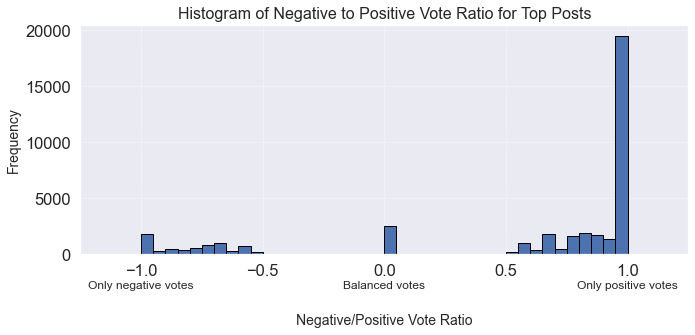

In [18]:
# Filter the data for "top posts" and plot a histogram for the Neg/Pos ratio
top_posts = df_merged[df_merged['Post_Engagement'] == 'top post']

# Set the style for a scientific paper look
plt.style.use('seaborn-deep')

# Create the figure and histogram
plt.figure(figsize=(10, 5))
plt.hist(top_posts['Neg_Pos_Ratio'].dropna(), bins=40, edgecolor='black')

# Title and labels
plt.title('Histogram of Negative to Positive Vote Ratio for Top Posts', fontsize=16)
plt.xlabel('Negative/Positive Vote Ratio', fontsize=14, labelpad=35)  # Add margin using labelpad
plt.ylabel('Frequency', fontsize=14)

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

# Annotate specific points using fixed positions relative to the x-axis
plt.annotate('Only positive votes', xy=(1, 0), xytext=(1, -0.15),  # Adjust text height below the x-axis
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
             )

plt.annotate('Balanced votes', xy=(0, 0), xytext=(0, -0.15),  # Adjust text height below the x-axis
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
            )

plt.annotate('Only negative votes', xy=(-1, 0), xytext=(-1, -0.15),  # Adjust text height below the x-axis
             textcoords=plt.gca().get_xaxis_transform(), ha='center', fontsize=12,
             bbox=dict(facecolor='white', edgecolor='none', pad=3),
             )

# Set x-axis limits for clarity
plt.xlim(-1.25, 1.25)

# Show the plot
plt.tight_layout()
plt.show()


In [19]:
df_merged.shape

(100000, 21)

In [20]:
df_merged['Total_Interaction'] = df_merged['PositiveVotes'] + df_merged['NegativeVotes']
df_merged['Neg_Pos_Ratio']

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
99995    1.0
99996    0.0
99997    1.0
99998    1.0
99999    1.0
Name: Neg_Pos_Ratio, Length: 100000, dtype: float64

In [21]:
df_merged['Post_Engagement'].value_counts()

regular post    61051
top post        38949
Name: Post_Engagement, dtype: int64

In [22]:
import re
import pandas as pd
import string
from textblob import TextBlob

# Feature extraction functions
def has_conjunctive(text):
    """Check for conjunctive words in German."""
    if pd.isnull(text):
        return 0
    conjunctive_words = ['wäre', 'könnte', 'müsste', 'sollte']  
    pattern = r'\b(?:' + '|'.join(conjunctive_words) + r')\b'
    return 1 if re.search(pattern, text) else 0

def has_question(text):
    """Check for question marks in the post."""
    if pd.isnull(text):
        return 0
    return 1 if '?' in text else 0

def has_spelling_mistakes(text):
    """Check for common spelling and syntax mistakes in German."""
    if pd.isnull(text) or len(text) == 0:
        return 0
    if re.search(r'\.\s*[a-zäöüß]', text):
        return 1
    if re.search(r'und[a-zäöüß]', text):
        return 1
    if re.search(r'oder[a-zäöüß]', text):
        return 1
    return 0

def has_gratitude(text):
    """Check for gratitude expressions in German."""
    if pd.isnull(text) or len(text) == 0:
        return 0
    if re.search(r'danke', text, re.IGNORECASE):
        return 1
    if re.search(r'bitte', text, re.IGNORECASE):
        return 1
    if re.search(r'lieb', text, re.IGNORECASE):
        return 1
    return 0

def has_keywords(text, keywords):
    """Check for specific keywords in the text."""
    if pd.isnull(text):
        return 0
    return 1 if any(keyword in text.lower() for keyword in keywords) else 0

# Feature extraction and integration
def extract_features(df):
    """Integrate all features into the baseline model."""
    # Text and headline length features
    df['BodyWordLength'] = df['Body'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    df['HeadlineWordLength'] = df['Headline'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    df['BodyLength'] = df['Body'].apply(lambda x: len(x) if isinstance(x, str) else 0)
    df['HeadlineLength'] = df['Headline'].apply(lambda x: len(x) if isinstance(x, str) else 0)

    # Linguistic features
    df['Conjunctive'] = df['Body'].apply(has_conjunctive)
    df['Question'] = df['Body'].apply(has_question)
    df['SpellingMistakes'] = df['Body'].apply(has_spelling_mistakes)
    df['Gratitude'] = df['Body'].apply(has_gratitude)

    # Sentiment features
    df['BodySentiment'] = df['Body'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0)
    df['HeadlineSentiment'] = df['Headline'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0)

    # Punctuation and special character features
    df['ExclamationMarks'] = df['Body'].apply(lambda x: x.count('!') if isinstance(x, str) else 0)
    df['UppercaseWordCount'] = df['Body'].apply(lambda x: len([word for word in x.split() if word.isupper()]) if isinstance(x, str) else 0)
    df['PunctuationCount'] = df['Body'].apply(lambda x: len([char for char in x if char in string.punctuation]) if isinstance(x, str) else 0)

    # Text complexity features
    df['AvgWordLength'] = df['Body'].apply(lambda x: sum(len(word) for word in x.split()) / len(x.split()) if isinstance(x, str) and len(x.split()) > 0 else 0)
    df['LexicalDiversity'] = df['Body'].apply(lambda x: len(set(x.split())) / len(x.split()) if isinstance(x, str) and len(x.split()) > 0 else 0)

    # Keyword, personal pronouns, and other textual features
    important_keywords = ['news', 'update', 'important', 'breaking']
    personal_pronouns = ['ich', 'wir', 'du']  # German personal pronouns
    df['HasImportantKeywords'] = df['Body'].apply(lambda x: has_keywords(x, important_keywords))
    df['HasPersonalPronouns'] = df['Body'].apply(lambda x: has_keywords(x, personal_pronouns))


    return df

# Apply feature extraction
df_merged = extract_features(df_merged)

# Define features for the baseline model
X_baseline2 = df_merged[['PositiveVotes', 'BodyWordLength', 'HeadlineWordLength', 
                         'BodyLength', 'HeadlineLength', 'Conjunctive', 
                         'Question', 'SpellingMistakes', 'Gratitude', 
                         'BodySentiment', 'HeadlineSentiment', 'ExclamationMarks', 
                         'UppercaseWordCount', 'PunctuationCount', 'AvgWordLength',
                         'LexicalDiversity', 'HasImportantKeywords', 
                         'HasPersonalPronouns', 
                         'time_passed_before_post_creation', 'time_percentile']]


In [23]:
df_merged

,ID_Post,ID_Parent_Post,ID_Article,ID_User,CreatedAt,Status,Headline,Body,PositiveVotes,NegativeVotes,...,Gratitude,BodySentiment,HeadlineSentiment,ExclamationMarks,UppercaseWordCount,PunctuationCount,AvgWordLength,LexicalDiversity,HasImportantKeywords,HasPersonalPronouns
0,18019,18001.0,268,497,2015-06-07 18:14:03.430,online,None,"Ja, ist ein hässliches Wort. Aber doch passend...",3,0,...,0,0.00000,0.0,0,0,8,5.000000,0.935484,0,1
1,9731,9728.0,141,15705,2015-06-03 12:33:36.640,online,None,"15.5.2015: Schlagzeile ""Bank Austria: Wachstum...",5,0,...,0,0.00000,0.0,0,1,30,7.203704,0.907407,0,1
2,11414,11408.0,157,10301,2015-06-04 09:26:18.503,online,So ist es ...,und wenn Sie mal due Gelegenheit dazu haben la...,2,0,...,0,-0.15625,0.0,1,0,3,5.342857,0.942857,0,1
3,91650,NaN,1314,16589,2015-07-05 20:56:03.037,online,Vielleicht ist es auch ganz interessant aus we...,None,2,0,...,0,0.00000,0.0,0,0,0,0.000000,0.000000,0,0
4,97976,97974.0,1395,21779,2015-07-07 17:11:05.460,online,None,"haha, der Klassiker!",6,0,...,0,0.25000,0.0,1,0,2,6.000000,1.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,20059,19998.0,328,27789,2015-06-08 21:30:13.980,online,None,"Charakter ist ein Politkarrierehindernis, aber...",1,0,...,0,0.00000,0.0,1,0,6,7.000000,1.000000,0,1
99996,95307,NaN,1358,14128,2015-07-17 17:19:21.930,online,Gleichheitswidrig...,"""Aber je nach Krankenkassa, bei der der Patien...",0,0,...,0,0.00000,0.0,0,1,16,6.227273,0.863636,0,1
99997,6555,6415.0,108,6169,2015-06-02 18:06:58.580,online,Die österreichische Lösung wäre,"eine stetig steigende Festplattengebühr,\r\nwo...",2,0,...,0,-0.50000,0.0,0,0,2,7.000000,1.000000,0,1
99998,88312,88248.0,1292,19516,2015-07-04 13:37:33.557,online,None,"so wie bei jedem Sport, auch z.B. Eishockey, R...",2,0,...,0,0.00000,0.0,0,0,7,5.300000,1.000000,0,0


## Step 3: Define Models

Next we define a function to train our models and we dfine our baselines

## Step 4: Train & Evaluate Models

## Regression Task

Finally we evaluate the models

In [24]:


# Define the training function with SGDRegressor
def train_model_regression(X_train, y_train):
    model = RandomForestRegressor(
                n_estimators=500,      # Start with fewer trees
                random_state=42,       
                n_jobs=-1,             
                max_depth=15,          # Limit depth to avoid overfitting
                min_samples_split=10,  # Require more samples to split
                min_samples_leaf=5,    # Require more samples at leaf
                max_features='sqrt'    # Consider fewer features at each split
            )
    model.fit(X_train, y_train)
    return model

# Define baseline models
baseline_models_regression = {
    'Baseline 1': df_merged[['PositiveVotes']].mean(),
    'Baseline 2': df_merged[['BodyWordLength', 'HeadlineWordLength', 'BodyLength', 'HeadlineLength']],
    'Baseline 3': df_merged[['BodyWordLength', 'HeadlineWordLength', 
                         'BodyLength', 'HeadlineLength', 'Conjunctive', 
                         'Question', 'SpellingMistakes', 'Gratitude', 
                         'BodySentiment', 'HeadlineSentiment', 'ExclamationMarks', 
                         'UppercaseWordCount', 'PunctuationCount', 'AvgWordLength',
                         'LexicalDiversity', 'HasImportantKeywords', 
                         'HasPersonalPronouns', 
                         'time_passed_before_post_creation', 'time_percentile']]
}

In [25]:
def evaluate_regression_model(y_train, y_test, y_pred_train, y_pred_test):
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    return mse_train, mse_test, mae_train, mae_test

def create_evaluation_df(model_name, mse_train, mse_test, mae_train, mae_test):
    return pd.DataFrame([
        {'Model': model_name, 'Evaluation': 'Train', 'MSE': mse_train, 'MAE': mae_train},
        {'Model': model_name, 'Evaluation': 'Test', 'MSE': mse_test, 'MAE': mae_test}
    ])

# Evaluate each baseline model
evaluation_dfs = []
for model_name, X_baseline in baseline_models_regression.items():
    y_train, y_test = train_test_split(df_posts['PositiveVotes'], test_size=0.2, random_state=42)
    
    if model_name == 'Baseline 1':
        # Special handling for Baseline 1
        y_pred_train = np.full_like(y_train, X_baseline)
        y_pred_test = np.full_like(y_test, X_baseline)
    else:
        # General case for other baselines
        X_train, X_test = train_test_split(X_baseline, test_size=0.2, random_state=42)
        model = train_model_regression(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

    mse_train, mse_test, mae_train, mae_test = evaluate_regression_model(y_train, y_test, y_pred_train, y_pred_test)
    evaluation_df = create_evaluation_df(model_name, mse_train, mse_test, mae_train, mae_test)
    evaluation_dfs.append(evaluation_df)

evaluation_df_posts = pd.concat(evaluation_dfs, ignore_index=True)
evaluation_df_posts_sorted = evaluation_df_posts.sort_values(by='Evaluation', ascending=False)
print(evaluation_df_posts_sorted)


        Model Evaluation        MSE       MAE
0  Baseline 1      Train  46.746925  3.622025
2  Baseline 2      Train  44.113105  3.721667
4  Baseline 3      Train  43.822273  3.713635
1  Baseline 1       Test  48.165250  3.636950
3  Baseline 2       Test  48.175023  3.830454
5  Baseline 3       Test  48.035292  3.833035


As we can see from the evaluation dataframe the Random Forest models currently overfit, an efford to tackle this issue will be part of the further development of this code.

## Classification Task

In [26]:
# Define the training function with RandomForestClassifier
def train_model_classification(X_train, y_train):
    model = RandomForestClassifier(
                n_estimators=500,      # Number of trees
                random_state=42,       
                n_jobs=-1,             # Use all processors
                max_depth=15,          # Limit depth to avoid overfitting
                min_samples_split=10,  # Require more samples to split
                min_samples_leaf=5,    # Require more samples at leaf
                max_features='sqrt'    # Consider fewer features at each split
            )
    model.fit(X_train, y_train)
    return model

# Define baseline models
baseline_models_classification = {
    'Baseline 1': df_merged['Post_Engagement'].mode()[0],  # Most frequent class (usually 'regular post')
    'Baseline 2': df_merged[['BodyWordLength', 'HeadlineWordLength', 'BodyLength', 'HeadlineLength']],
    'Baseline 3': df_merged[['BodyWordLength', 'HeadlineWordLength', 
                         'BodyLength', 'HeadlineLength', 'Conjunctive', 
                         'Question', 'SpellingMistakes', 'Gratitude', 
                         'BodySentiment', 'HeadlineSentiment', 'ExclamationMarks', 
                         'UppercaseWordCount', 'PunctuationCount', 'AvgWordLength',
                         'LexicalDiversity', 'HasImportantKeywords', 
                         'HasPersonalPronouns', 
                         'time_passed_before_post_creation', 'time_percentile']]
}

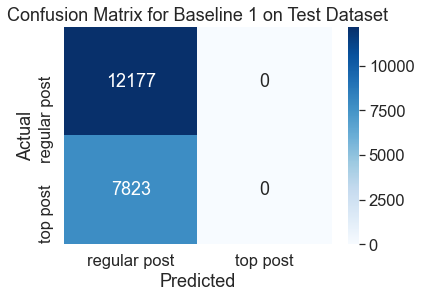

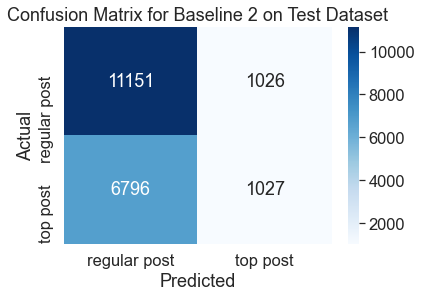

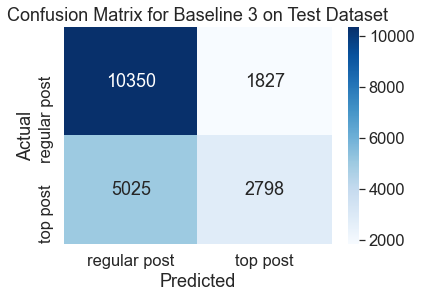

        Model Evaluation  Accuracy  Precision    Recall        F1
0  Baseline 1      Train  0.610925   0.000000  0.000000  0.000000
2  Baseline 2      Train  0.679375   0.816972  0.226724  0.354944
4  Baseline 3      Train  0.746075   0.786851  0.476418  0.593492
1  Baseline 1       Test  0.608850   0.000000  0.000000  0.000000
3  Baseline 2       Test  0.608900   0.500244  0.131280  0.207979
5  Baseline 3       Test  0.657400   0.604973  0.357663  0.449550


In [27]:
def calculate_classification_metrics(y_true, y_pred):
    """Calculate and return classification metrics."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label='top post', zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label='top post', zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label='top post', zero_division=0)
    return accuracy, precision, recall, f1

def plot_confusion_matrix(y_true, y_pred, model_name):
    """Plot the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, labels=['regular post', 'top post'])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['regular post', 'top post'], 
                yticklabels=['regular post', 'top post'])
    plt.title(f'Confusion Matrix for {model_name} on Test Dataset')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def evaluate_model_classification(y_train, y_test, model=None, predict_baseline=False):
    """Evaluate model or baseline classification."""
    if predict_baseline:
        y_pred_train = ['regular post'] * len(y_train)
        y_pred_test = ['regular post'] * len(y_test)
    else:
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

    metrics_train = calculate_classification_metrics(y_train, y_pred_train)
    metrics_test = calculate_classification_metrics(y_test, y_pred_test)
    
    return metrics_train + metrics_test, y_pred_test

def create_evaluation_df(model_name, metrics):
    """Create a DataFrame for model evaluation results."""
    return pd.DataFrame([
        {'Model': model_name, 'Evaluation': 'Train', 'Accuracy': metrics[0], 'Precision': metrics[1], 'Recall': metrics[2], 'F1': metrics[3]},
        {'Model': model_name, 'Evaluation': 'Test', 'Accuracy': metrics[4], 'Precision': metrics[5], 'Recall': metrics[6], 'F1': metrics[7]}
    ])




# Evaluate each model and plot confusion matrix
evaluation_dfs = []
examples_df = pd.DataFrame(columns=['ModelName',  # which baseline
                                    'Type', #weather true positive (tp), true negative (tn), fp or fn
                                    'Example', # the body of that example
                                    'PositiveVotes',
                                    'NegativeVotes'])

for model_name, X_baseline in baseline_models_classification.items():
    y_train, y_test = train_test_split(df_merged['Post_Engagement'], test_size=0.2, random_state=42)

    if model_name == 'Baseline 1':
        metrics, y_pred_test = evaluate_model_classification(y_train, y_test, predict_baseline=True)
    else:
        X_train, X_test = train_test_split(X_baseline, test_size=0.2, random_state=42)
        model = train_model_classification(X_train, y_train)
        metrics, y_pred_test = evaluate_model_classification(y_train, y_test, model=model)
        
    

    evaluation_df = create_evaluation_df(model_name, metrics)
    evaluation_dfs.append(evaluation_df)
    

    # Plot confusion matrix for test dataset
    plot_confusion_matrix(y_test, y_pred_test, model_name)
    


    # Collect examples of each kind (tp, tn, fp, fn)
    examples = {'True Positive': None, 'True Negative': None, 'False Negative': None, 'False Positive': None}

    for i in range(len(y_test)):
        example_data = {
            'ModelName': model_name,
            'Example': df_merged['Body'].iloc[X_test.index[i]],
            'PositiveVotes': df_merged['PositiveVotes'].iloc[X_test.index[i]],
            'NegativeVotes': df_merged['NegativeVotes'].iloc[X_test.index[i]]
        }

        if y_test.iloc[i] == 'top post':
            if y_pred_test[i] == 'top post' and examples['True Positive'] is None:
                examples['True Positive'] = {**example_data, 'Type': 'True Positive'}
            elif y_pred_test[i] == 'regular post' and examples['False Negative'] is None:
                examples['False Negative'] = {**example_data, 'Type': 'False Negative'}
        elif y_pred_test[i] == 'top post' and examples['False Positive'] is None:
            examples['False Positive'] = {**example_data, 'Type': 'False Positive'}
        elif y_pred_test[i] == 'regular post' and examples['True Negative'] is None:
            examples['True Negative'] = {**example_data, 'Type': 'True Negative'}

    # Append collected examples to examples_df
    for example_type, example in examples.items():
        if example is None:
            example = {
                'ModelName': model_name,
                'Type': example_type,
                'Example': None,
                'PositiveVotes': None,
                'NegativeVotes': None
            }
        examples_df = examples_df.append(example, ignore_index=True)

# Combine evaluation results into one DataFrame
evaluation_df_posts = pd.concat(evaluation_dfs, ignore_index=True)
evaluation_df_posts_sorted = evaluation_df_posts.sort_values(by='Evaluation', ascending=False)
print(evaluation_df_posts_sorted)


In [28]:
examples_df

,ModelName,Type,Example,PositiveVotes,NegativeVotes
0,Baseline 1,True Positive,None,None,None
1,Baseline 1,True Negative,Die seit Tagen geschlossenen Banken in Grieche...,1,0
2,Baseline 1,False Negative,"""Die Türken haben Tayyip Erdogan abgestraft.""\...",4,2
3,Baseline 1,False Positive,None,None,None
4,Baseline 2,True Positive,... aus Solidaritätsgründen für das ganze Digi...,0,4
5,Baseline 2,True Negative,Die seit Tagen geschlossenen Banken in Grieche...,1,0
6,Baseline 2,False Negative,"""Die Türken haben Tayyip Erdogan abgestraft.""\...",4,2
7,Baseline 2,False Positive,Das müssten Sie erstmal belegen - da werden Si...,0,0
8,Baseline 3,True Positive,Ich bin echt einer der wenigen Idioten der täg...,19,0
9,Baseline 3,True Negative,Die seit Tagen geschlossenen Banken in Grieche...,1,0


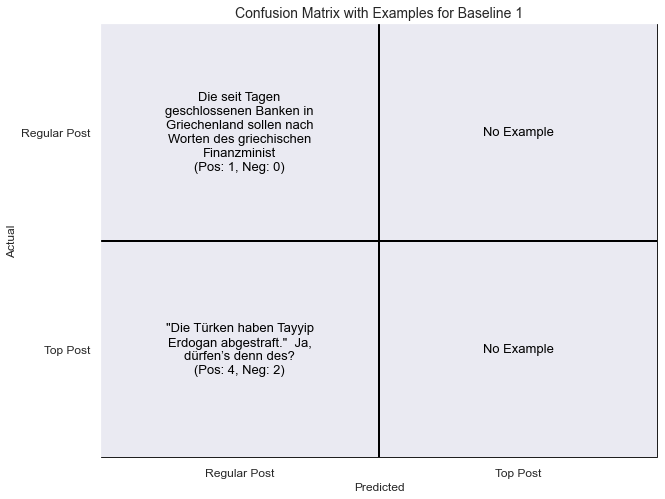

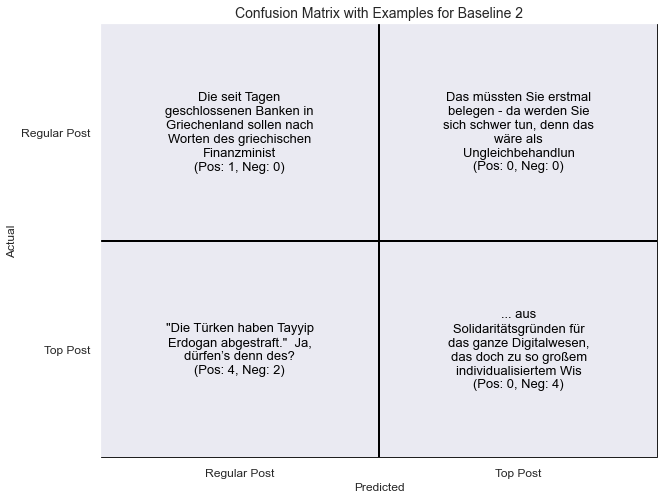

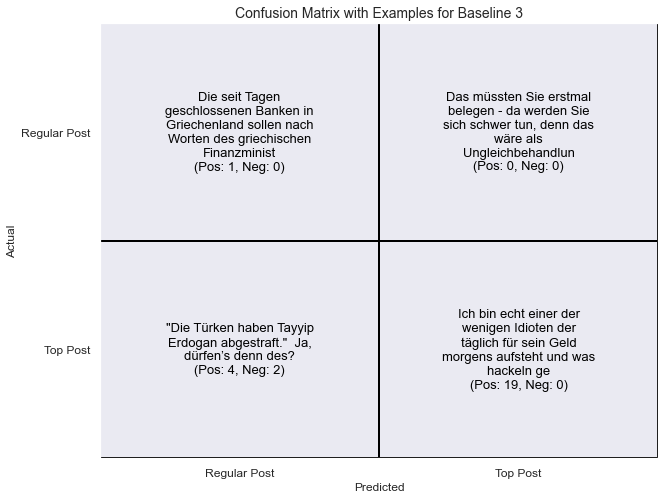

In [29]:
import matplotlib.pyplot as plt
import textwrap

def format_example_text(example_text, pos_votes, neg_votes):
    """Format example text to display only the first 100 characters with line breaks every 25 characters."""
    if example_text:
        # Limit to 100 characters
        truncated_text = example_text[:100]
        # Create line breaks every 25 characters without cutting words
        wrapped_text = textwrap.fill(truncated_text, width=25)
        return f"{wrapped_text}\n(Pos: {pos_votes}, Neg: {neg_votes})"
    return "No Example"

def plot_confusion_matrix_of_examples(examples_df, model_name):
    """Plot the confusion matrix using the examples dataframe."""
    labels = ['Regular Post', 'Top Post']
    cm = [[0, 0], [0, 0]]  # Initialize confusion matrix counts

    # Fill confusion matrix based on examples_df
    for _, row in examples_df.iterrows():
        if row['Type'] == 'True Positive':
            cm[1][1] += 1
        elif row['Type'] == 'True Negative':
            cm[0][0] += 1
        elif row['Type'] == 'False Positive':
            cm[0][1] += 1
        elif row['Type'] == 'False Negative':
            cm[1][0] += 1

    plt.figure(figsize=(10, 8))  # Increase the overall size

    # Create a grid for the confusion matrix
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            # Draw rectangle for each cell
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='black', lw=2))
            # Only annotate if there's a count
            if cm[i][j] > 0:
                # Find the corresponding example
                example_row = examples_df[(examples_df['Type'] == ('True Positive' if i == 1 and j == 1 else
                                                                    'True Negative' if i == 0 and j == 0 else
                                                                    'False Positive' if i == 0 and j == 1 else
                                                                    'False Negative'))]
                
                # Fetch the corresponding example text
                if not example_row.empty:
                    example = example_row.iloc[0]
                    formatted_text = format_example_text(example['Example'], 
                                                          example['PositiveVotes'], 
                                                          example['NegativeVotes'])
                else:
                    formatted_text = "No Example"
                    
                # Place the text in the center of each cell
                plt.text(j + 0.5, i + 0.5, formatted_text, ha='center', va='center', 
                         fontsize=13, color='black')

    # Set axis limits and labels
    plt.xlim(0, len(cm[0]))
    plt.ylim(0, len(cm))
    plt.title(f'Confusion Matrix with Examples for {model_name}', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.xticks([0.5, 1.5], labels, fontsize=12)
    plt.yticks([0.5, 1.5], labels, fontsize=12)
    plt.gca().invert_yaxis()  # Invert y axis to have the origin in the top left

    plt.grid(False)  # Disable the grid
    plt.axis('on')  # Show the axes
    plt.show()

# Example call to plot the confusion matrix using examples_df
for model_name in examples_df['ModelName'].unique():
    model_examples_df = examples_df[examples_df['ModelName'] == model_name]
    plot_confusion_matrix_of_examples(model_examples_df, model_name)


In [41]:

# Preprocessing step to replace None with empty strings
df_merged['Body'] = df_merged['Body'].fillna('')
df_merged['Headline'] = df_merged['Headline'].fillna('')

# Tokenize and pad the textual data
def preprocess_text_column(column, tokenizer=None, max_len=100):
    if tokenizer is None:
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(column)
    
    sequences = tokenizer.texts_to_sequences(column)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    
    return padded_sequences, tokenizer

# Scale the temporal features
scaler = StandardScaler()
temporal_features = df_merged[['time_passed_before_post_creation', 'time_percentile']]
temporal_features_scaled = scaler.fit_transform(temporal_features)

# Prepare text columns
max_len = 100  # Set max length for the sequences
X_body, body_tokenizer = preprocess_text_column(df_merged['Body'], max_len=max_len)
X_headline, headline_tokenizer = preprocess_text_column(df_merged['Headline'], max_len=max_len)

# Prepare labels
y = (df_merged['Post_Engagement'] == 'top post').astype(int)  # Binary labels

# Split into training and test sets
X_train_body, X_test_body, X_train_headline, X_test_headline, X_train_temporal, X_test_temporal, y_train, y_test = train_test_split(
    X_body, X_headline, temporal_features_scaled, y, test_size=0.2, random_state=42)



In [52]:
# Define hyperparameters
embedding_dim = 64
lstm_units = 64

# Textual input: Body
input_body = Input(shape=(max_len,), name='body_input')
embedding_body = Embedding(input_dim=len(body_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_body)
lstm_body = LSTM(lstm_units)(embedding_body)

# Textual input: Headline
input_headline = Input(shape=(max_len,), name='headline_input')
embedding_headline = Embedding(input_dim=len(headline_tokenizer.word_index) + 1, output_dim=embedding_dim)(input_headline)
lstm_headline = LSTM(lstm_units)(embedding_headline)

# Temporal features input
input_temporal = Input(shape=(2,), name='temporal_input')

# Concatenate all inputs
concatenated = concatenate([lstm_body, lstm_headline, input_temporal])

# Output layer
output = Dense(1, activation='sigmoid')(concatenated)

# Define the model
model = Model(inputs=[input_body, input_headline, input_temporal], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 body_input (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 headline_input (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 100, 64)      10704832    ['body_input[0][0]']             
                                                                                                  
 embedding_15 (Embedding)       (None, 100, 64)      2176704     ['headline_input[0][0]']         
                                                                                            

In [36]:
# Train the LSTM model
history = model.fit(
    [X_train_body, X_train_headline, X_train_temporal], y_train,
    epochs=10,  # Adjust number of epochs based on model performance
    batch_size=32,
    validation_split=0.2
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate([X_test_body, X_test_headline, X_test_temporal], y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict the labels on test data
y_pred_test = (model.predict([X_test_body, X_test_headline, X_test_temporal]) > 0.5).astype(int)


Epoch 1/10
2000/2000 [==============================] - 273s 135ms/step - loss: 0.6381 - accuracy: 0.6309 - val_loss: 0.6287 - val_accuracy: 0.6379
Epoch 2/10
2000/2000 [==============================] - 273s 137ms/step - loss: 0.6235 - accuracy: 0.6445 - val_loss: 0.6362 - val_accuracy: 0.6355
Epoch 3/10
2000/2000 [==============================] - 266s 133ms/step - loss: 0.5950 - accuracy: 0.6620 - val_loss: 0.6525 - val_accuracy: 0.6372
Epoch 4/10
2000/2000 [==============================] - 269s 135ms/step - loss: 0.5683 - accuracy: 0.6868 - val_loss: 0.6768 - val_accuracy: 0.6433
Epoch 5/10
2000/2000 [==============================] - 279s 140ms/step - loss: 0.5054 - accuracy: 0.7468 - val_loss: 0.7161 - val_accuracy: 0.6256
Epoch 6/10
2000/2000 [==============================] - 272s 136ms/step - loss: 0.4051 - accuracy: 0.8153 - val_loss: 0.7875 - val_accuracy: 0.6086
Epoch 7/10
2000/2000 [==============================] - 277s 139ms/step - loss: 0.2818 - accuracy: 0.8762 - val_

Accuracy: 0.5780, Precision: 0.4563, Recall: 0.4122, F1 Score: 0.4332


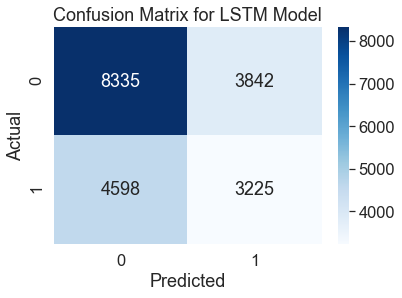

In [37]:
# Calculate evaluation metrics
def calculate_classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    return accuracy, precision, recall, f1

# Calculate metrics for the LSTM model
metrics_test = calculate_classification_metrics(y_test, y_pred_test)
print(f"Accuracy: {metrics_test[0]:.4f}, Precision: {metrics_test[1]:.4f}, Recall: {metrics_test[2]:.4f}, F1 Score: {metrics_test[3]:.4f}")

# Plot confusion matrix
def plot_confusion_matrix_lstm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for LSTM Model')
    plt.show()

plot_confusion_matrix_lstm(y_test, y_pred_test)
